## 1. MNIST Data Load 

<br/>
**Note**: 일반적으로 이미지 데이터를 읽어들이게되면 numpy의 dtype("uint8")으로 저장이 됩니다. uint8은 0~255 사이의 값으로 표현되며, 이를 "0"과 "1"사이의 데이터로 정규화하기 위해서 255로 나누어주는 과정을 거칩니다.
<br/><br/>

In [1]:
import numpy as np
import gzip
import struct
import matplotlib.pyplot as plt
import sys
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 20)

Populating the interactive namespace from numpy and matplotlib


In [2]:
# MNIST Data Load
def read_data(label_path, image_path):
    with gzip.open(label_path) as flbl:
        _, _ = struct.unpack(">II", flbl.read(8))
        label = np.fromstring(flbl.read(), dtype=np.int8)
    with gzip.open(image_path, 'rb') as fimg:
        _, _, rows, cols = struct.unpack(">IIII", fimg.read(16))
        image = np.fromstring(fimg.read(), dtype=np.uint8).reshape(len(label), rows, cols)
    return (label, image)

In [3]:
path = "data/"
(train_label, train_img) = read_data(path+'train-labels-idx1-ubyte.gz', path+'train-images-idx3-ubyte.gz')
(val_label, val_img) = read_data(path+'t10k-labels-idx1-ubyte.gz', path+'t10k-images-idx3-ubyte.gz')

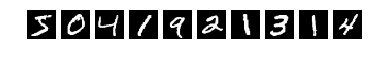

In [4]:
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(train_img[i], cmap='Greys_r')
    plt.axis('off')

plt.show()

train_label = train_label.astype(np.int64)
train_img = train_img.astype(np.float32) / 255
val_label = val_label.astype(np.int64)
val_img = val_img.astype(np.float32) / 255

## 2 - Forward Operation

<br/>

1. `먼저 입력 데이터의 차원에 맞게, 가중치 행렬을 생성하고 초기화합니다.`
2. `초기화된 Weights와 bias를 입력 데이터를 이용해서 $Y = WX + b$을 구합니다.`
3. `ACTIVATION (Sigmoid, ReLU etc)를 이용해서 최종 출력을 얻습니다.`


<img src="images/perceptron.png" style="width:650px;height:300px;">
<caption><center> <u>Figure 1</u>: Forward Operation. <br> The model can be summarized as: ***[INPUT -> LINEAR -> ACTIVATION]***</center></caption>

<br/>
위의 그림을 수식으로 일반화하면, 아래와 같습니다
<br/><br/>

$$Z = W X + b$$

<br/><br/>

<table style="width:100%">
<br/>

`Python`에서 `Numpy`를 사용해서 $W X + b$를 계산할 때, $b$는 자동으로 차원이 맞춰지는 broadcasting과정을 거칩니다.

아래는 broadcasting이라는 과정을 보여줍니다 : 


$$ W = \begin{bmatrix}
    j  & k  & l\\
    m  & n & o \\
    p  & q & r 
\end{bmatrix}\;\;\; X = \begin{bmatrix}
    a  & b  & c\\
    d  & e & f \\
    g  & h & i 
\end{bmatrix} \;\;\; b =\begin{bmatrix}
    s  \\
    t  \\
    u
\end{bmatrix}\tag{2}$$

<br/><br/><br/>
위와 같이 계산하면 $WX + b$ 아래와 같은 식이 됩니다 : 

$$ WX + b = \begin{bmatrix}
    (ja + kd + lg) + s  & (jb + ke + lh) + s  & (jc + kf + li)+ s\\
    (ma + nd + og) + t & (mb + ne + oh) + t & (mc + nf + oi) + t\\
    (pa + qd + rg) + u & (pb + qe + rh) + u & (pc + qf + ri)+ u
\end{bmatrix}\tag{3}  $$

### 2-1. Initialization

- 데이터 차원에 맞게 가중치 행렬을 생성하고 초기화합니다.
- 일반적으로 weights는 난수로, bias는 0으로 초기화합니다.

In [5]:
def init_params(input_dims, output_dims):
    np.random.seed(1)

    W = np.random.randn(output_dims, input_dims) * 0.1
    b = np.zeros(shape=(output_dims, 1))

    assert (W.shape == (output_dims, input_dims))
    assert (b.shape == (output_dims, 1))

    parameters = {"W": W,
                  "b": b,
                  }

    return parameters

In [6]:
parameters = init_params(2,2)
print("W1 = " + str(parameters["W"].reshape(1,4)))
print("b1 = " + str(parameters["b"].reshape(1,2)))

W1 = [[ 0.16243454 -0.06117564 -0.05281718 -0.10729686]]
b1 = [[ 0.  0.]]


**Expected output**:
       
<table style="width:80%">
  <tr>
    <td> **W1** </td>
    <td> [[ 0.16243454 -0.06117564]
 [-0.05281718 -0.10729686]] </td> 
  </tr>

  <tr>
    <td> **b1**</td>
    <td>[[ 0.]
 [ 0.]]</td> 
  </tr>
</table>
<br/><br/><br/>

### 2-2. Linear Forward Module

Linear Forward Module은 아래와 같은 수식으로 일반화되어 계산됩니다.

$$Z^{[l]} = W^{[l]}A^{[l-1]} +b^{[l]}\tag{4}$$

여기서 $A^{[0]} = X$. <br/><br/>
즉, $A^{[l-1]}$은 이전 레이어에서 온 출력값이고, $A^{[0]}$. 이전 레이어의 처음값은 입력 데이터라는 의미입니다.
<br/>
<br/>

In [7]:
def linear_forward(A, W, b):
    Z = np.dot(W, A) + b
    assert (Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)

    return Z, cache

In [8]:
# Input Data Reshape
X = train_img[0].reshape(1,784)
# Init Params
parameters = init_params(784,10)
W, b = parameters["W"], parameters["b"]

print("key of parameters : {}".format(parameters.keys()))
print("X's dimensions : {}, W shape : {}, b shape : {}".format(X.shape, W.shape, b.shape))
print("Matrix Multiply : {} x {} = ({},{})".format(W.shape, X.T.shape, W.shape[0], X.shape[0]))
Z, _ = linear_forward(X.T, W, b)
print("Z Shape : {}".format(Z.shape), end="\n\n\n")

print("Z = " + str(Z.reshape(1,10)))

key of parameters : dict_keys(['b', 'W'])
X's dimensions : (1, 784), W shape : (10, 784), b shape : (10, 1)
Matrix Multiply : (10, 784) x (784, 1) = (10,1)
Z Shape : (10, 1)


Z = [[ 0.01744896 -0.60502108  0.76272153  0.29953858 -1.3981822   0.48902655
   0.70858887 -0.29736435 -0.08814531  0.32212843]]


**Expected output**:
       
<table style="width:100%">
  <tr>
    <td> **Z** </td>
    <td>[[ 0.01744896 -0.60502108  0.76272153  0.29953858 -1.3981822   0.48902655
   0.70858887 -0.29736435 -0.08814531  0.32212843]]</td> 
  </tr>
</table>
<br/><br/><br/>

### 2-3. Linear-Activateion Forward

이번 예제에서는 2가지 종류의 Activation function을 사용합니다.


- **Sigmoid**: $\sigma(Z) = \sigma(W A + b) = \frac{1}{ 1 + e^{-(W A + b)}}$. <br/><br/> `sigmoid` 함수는 **2개**의 return 값을 갖습니다 : activation value "`a`", "`Z`"를 포함하고 있는 "`cache`" (Backpropagation때, 이를 사용합니다). <br/><br/>사용법은 다음과 같습니다: 
``` python
A, activation_cache = sigmoid(Z)
```

<img src="images/sigmoid.png" style="width:650px;height:300px;">
<caption><center> <u>Figure 2</u>: Sigmoid.</center></caption>

- **ReLU**: $A = ReLU(Z) = max(0, Z)$.<br/><br/> `relu` 함수는 **2개**의 return값을 갖습니다.: the activation value "`A`", "`Z`"를 포함하고 있는"`cache`" (Backpropagation때, 이를 사용합니다). <br/><br/>사용법은 다음과 같습니다:
``` python
A, activation_cache = relu(Z)
```
<img src="images/relu.jpeg" style="width:650px;height:300px;">
<caption><center> <u>Figure 3</u>: ReLU.</center></caption>

- **Sigmoid의 미분**: <br/> $g'(Z) = \frac{ d }{ dz }\frac{ 1 }{ 1+e^{-z} } = \frac{1}{(1+e^-z)^2}(e^{-z}) = \frac{1}{1+e^{-z}}(1-\frac{1}{1+e^{-z}}) = g(z)(1-g(z))$<br/><br/>

- **ReLU의 미분**: <br/> $g'(Z) = \max(0, Z)$

In [9]:
def derivative_sigmoid(Z):
    return (1/(1+np.exp(-Z)) * (1-1/(1+np.exp(-Z))))

def derivative_relu(Z):
    return 1. * (Z > 0)

def sigmoid(Z):
    # Prevent numpy.exp Overflow Error
    Z = Z.astype("float128")
    return 1/(1+np.exp(-Z)), derivative_sigmoid(Z)

def relu(Z):
    return np.maximum(0, Z), derivative_relu(Z)

Text(0.5,1,'derivative ReLU')

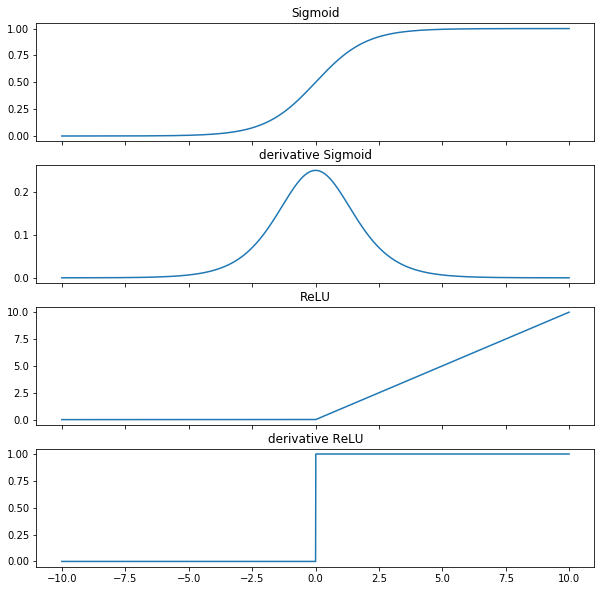

In [10]:
tmp = [round(i*0.01, 5) for i in range(-1000,1000)]
x = np.asarray(tmp)

f, axarr = plt.subplots(4, sharex=True)
f.set_figheight(10)
f.set_figwidth(10)
sig, derivate_sig = sigmoid(x)
ReLU, derivate_relu = relu(x)
axarr[0].plot(x, sig)
axarr[0].set_title("Sigmoid")
axarr[1].plot(x, derivate_sig)
axarr[1].set_title("derivative Sigmoid")
axarr[2].plot(x, ReLU)
axarr[2].set_title("ReLU")
axarr[3].plot(x, derivate_relu)
axarr[3].set_title("derivative ReLU")

In [11]:
def linear_activation_forward(A_prev, W, b, activation):

    Z, linear_cache = linear_forward(A_prev, W, b)
    if activation == "sigmoid":
        A, activation_cache = sigmoid(Z)

    elif activation == "relu":
        A, activation_cache = relu(Z)
    
    elif activation == "softmax":
        A, activation_cache = softmax(Z)

    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache

In [12]:
# Input Data Reshape
X = train_img[0].reshape(1,784)
# Init Params
parameters = init_params(784,10)
W, b = parameters["W"], parameters["b"]

print("key of parameters : {}".format(parameters.keys()))
print("X's dimensions : {}, W shape : {}, b shape : {}".format(X.shape, W.shape, b.shape))
print("Matrix Multiply : {} x {} = ({},{})".format(W.shape, X.T.shape, W.shape[0], X.shape[0]))
A, _ = linear_activation_forward(X.T, W, b, "sigmoid")
print("A Shape : {}".format(A.shape), end="\n\n\n")

print("A = " + str(A.reshape(1,10)))

key of parameters : dict_keys(['b', 'W'])
X's dimensions : (1, 784), W shape : (10, 784), b shape : (10, 1)
Matrix Multiply : (10, 784) x (784, 1) = (10,1)
A Shape : (10, 1)


A = [[ 0.50436213  0.35319579  0.68194431  0.57432971  0.19810473  0.61987708
   0.67008928  0.42620191  0.47797793  0.57984288]]


**Expected output**:
       
<table style="width:100%">
  <tr>
    <td> **With sigmoid: A ** </td>
    <td > [[ 0.50436213  0.35319579  0.68194431  0.57432971  0.19810473  0.61987708
   0.67008928  0.42620191  0.47797793  0.57984288]</td> 
  </tr>
</table>

## 3 - Cost Function

지금까지 Muli Layer Forward Operation을 구현하였습니다.

이번엔 Forward Operation의 결과와 label 값을 통해서 나온 결과를 비교해서 비용함수를 구현하도록 하겠습니다.

**Exercise**: 여기서는 cross-entropy cost $J$를 계산합니다, 수식은 다음과 같습니다.: $$-\frac{1}{m} \sum\limits_{i = 1}^{m} (y^{(i)}\log\left(a^{[L] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right)) \tag{7}$$


In [13]:
def compute_cost(AL, Y):
    m = Y.shape[0]

    # MSE Error
    cost = (1 / m) * np.sum(np.square(Y-AL))
    cost = np.squeeze(cost)
    assert (cost.shape == ())

    return cost

In [14]:
classes = 10

# Input Data Reshape
X = train_img[0].reshape(1,784)

# Label Data
label = np.array([int(i==int(train_label[0])) for i in range(classes)]).reshape(classes,1)

# Init Params
parameters = init_params(784,10)
W, b = parameters["W"], parameters["b"]
print("key of parameters : {}".format(parameters.keys()))
print("X's dimensions : {}, W shape : {}, b shape : {}".format(X.shape, W.shape, b.shape))
print("Matrix Multiply : {} x {} = ({},{})".format(W.shape, X.T.shape, W.shape[0], X.shape[0]))

# Forward Operation
A, _ = linear_activation_forward(X.T, W, b, "sigmoid")
print("A = " + str(A.reshape(1,10)), end="\n\n\n")

# Calc Cost
cost = compute_cost(A, label)
print("Cost : {}".format(cost))

key of parameters : dict_keys(['b', 'W'])
X's dimensions : (1, 784), W shape : (10, 784), b shape : (10, 1)
Matrix Multiply : (10, 784) x (784, 1) = (10,1)
A = [[ 0.50436213  0.35319579  0.68194431  0.57432971  0.19810473  0.61987708
   0.67008928  0.42620191  0.47797793  0.57984288]]


Cost : 0.25531183849673833


**Expected Output**:

<table>

    <tr>
    <td>**cost** </td>
    <td> 0.25531183849673833</td> 
    </tr>
</table>

## 4 - Backward propagation module

전파 알고리즘과 마찬가지로 역전파 알고리즘을 위한 함수를 구현합니다. 

**Reminder**: 
<img src="images/backprop_kiank.png" style="width:650px;height:250px;">
<caption><center> **Figure 3** : Forward and Backward propagation for *LINEAR->RELU->LINEAR->SIGMOID* <br> *The purple blocks represent the forward propagation, and the red blocks represent the backward propagation.*  </center></caption>

<br/><br/>

2-layer 기반 인공신경망의 체인 룰에 따른 Loss에 대한 미분식은 다음과 같습니다.

$\mathcal{L}$에 대한 $z^{[1]}$의 미분:

$$\frac{d \mathcal{L}(a^{[2]},y)}{{dz^{[1]}}} = \frac{d\mathcal{L}(a^{[2]},y)}{{da^{[2]}}}\frac{{da^{[2]}}}{{dz^{[2]}}}\frac{{dz^{[2]}}}{{da^{[1]}}}\frac{{da^{[1]}}}{{dz^{[1]}}} \tag{8} $$

위 식에 따라서 $dW^{[1]}$을 계산하면 아래와 같습니다.

$dW^{[1]} = \frac{\partial L}{\partial W^{[1]}}$

체인룰에 따라 $dW^{[1]}$을 풀면 아래와 같습니다. 

$dW^{[1]} = dz^{[1]} \times \frac{\partial z^{[1]} }{\partial W^{[1]}}$. 

이런 형태로 체인룰에 따라서 내부식을 풀면, 각 에러들은 각 노드들의 미분값의 곱이라는 것을 확인할 수 있습니다.

$db^{[1]}$은 다음과 같이 표현할 수 있습니다.

$db^{[1]} = \frac{\partial L}{\partial b^{[1]}}$

$db^{[1]} = dz^{[1]} \times \frac{\partial z^{[1]} }{\partial b^{[1]}}$.

### 4.1 - Linear backward

$l$ 레이어의 linear 연산은 다음과 같습니다. 

$Z^{[l]} = W^{[l]} A^{[l-1]} + b^{[l]}$

$l$ 레이어의 미분값은 아래와 같은 식을 통해서 이미 계산되었다고 가정했을 때, 

$dZ^{[l]} = \frac{\partial \mathcal{L} }{\partial Z^{[l]}}$. 

우리는 $dW^{[l]}, db^{[l]} dA^{[l-1]}$의 미분값들을 모두 구할 수 있습니다.

<img src="images/linearback_kiank.png" style="width:250px;height:300px;">
<caption><center> **Figure 4** </center></caption>

$(dW^{[l]}, db^{[l]}, dA^{[l]})$의 미분값들은 아래의 수식을 통해서 구할 수 있습니다.


$$ dW^{[l]} = \frac{\partial \mathcal{L} }{\partial W^{[l]}} = \frac{1}{m} dZ^{[l]} A^{[l-1] T} \tag{8}$$
$$ db^{[l]} = \frac{\partial \mathcal{L} }{\partial b^{[l]}} = \frac{1}{m} \sum_{i = 1}^{m} dZ^{[l](i)}\tag{9}$$
$$ dA^{[l-1]} = \frac{\partial \mathcal{L} }{\partial A^{[l-1]}} = W^{[l] T} dZ^{[l]} \tag{10}$$


### 4.2 - Linear-Activation backward

다음으로 우리는 `Activation Function`에 대한 미분값을 구하는 함수를 구현할 수 있습니다.

`Activation Function`에 대한 미분값들은 각 `Activation Function`마다 다르며, 

$g(.)$이 `Activation Function`이라고 할 때, 아래와 같이 구현할 수 있습니다.

$$dZ^{[l]} = dA^{[l]} * g'(Z^{[l]}) \tag{11}$$.

In [15]:
def relu_backward(dA, activation_cache):
    return np.multiply(dA, activation_cache)

def sigmoid_backward(dA, activation_cache):
    return np.multiply(dA, activation_cache)

def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = np.dot(dZ, A_prev.T) / m
    db = np.reshape(np.squeeze(np.sum(dZ, axis=1, keepdims=True)) / m, b.shape)
    dA_prev = np.dot(W.T, dZ)

    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)

    return dA_prev, dW, db

def linear_activation_backward(dA, cache, activation):
    linear_cache, activation_cache = cache

    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)

    dA_prev, dW, db = linear_backward(dZ, linear_cache)

    return dA_prev, dW, db

In [16]:
classes = 10

# Input Data Reshape
X = train_img[0].reshape(1,784)

# Label Data
label = np.array([int(i==int(train_label[0])) for i in range(classes)]).reshape(classes,1)

# Init Params
layer1_parameters = init_params(784,1)
layer2_parameters = init_params(1,10)

parameters = {
    "W1"    :   layer1_parameters["W"],
    "b1"    :   layer1_parameters["b"],
    "W2"    :   layer2_parameters["W"],
    "b2"    :   layer2_parameters["b"]
}

# Forward Operation
A1, layer1_cache = linear_activation_forward(X.T, parameters["W1"], parameters["b1"], "sigmoid")
A2, layer2_cache = linear_activation_forward(A1, parameters["W2"], parameters["b2"], "sigmoid")

# Calc Cost
Cost = compute_cost(A2, label)

# Derivative cost
m = label.shape[0]
dCost = (-2/m)*(label-A2)

dA_2, dW2, db2 = linear_activation_backward(dCost, layer2_cache, "sigmoid")
print("dA_2 : {}".format(dA_2))
print("dW2 : {}".format(dW2.reshape(1,10)))
print("db2 : {}".format(db2.reshape(1,10)))

dA_2 : [[ 0.009944385]]
dW2 : [[ 0.013103269  0.01241159  0.01243891  0.01225898  0.012878054 -0.01329523
   0.013138052  0.012362481  0.012709675  0.012529265]]
db2 : [[ 0.025979883  0.02460849  0.024662657  0.024305909  0.025533349
  -0.026360484  0.026048847  0.024511121  0.025199503  0.024841803]]


**Expected Output**: 

<table style="width:90%">
  <tr>
    <td> **dA_2** </td>
    <td > [[ 0.009944385]]</td> 
  </tr> 
  <tr>
        <td> **dW2** </td>
        <td > [[ 0.013103269  0.01241159  0.01243891  0.01225898  0.012878054 -0.01329523
   0.013138052  0.012362481  0.012709675  0.012529265]] </td> 
  </tr> 
  <tr>
        <td> **db2** </td>
        <td> [[ 0.025979883  0.02460849  0.024662657  0.024305909  0.025533349
  -0.026360484  0.026048847  0.024511121  0.025199503  0.024841803]]</td> 
  </tr> 
    
</table>


### 4.4 - Update Parameters

이제 우리는 여태까지 구한 미분값들을 통해서 전파되어야하는 에러값들을 계산했고, 

아래의 `경사하강법(Gradient Descent)`을 통해서 각 가중치들을 업데이트할 수 있습니다.

$$ W^{[l]} = W^{[l]} - \alpha \text{ } dW^{[l]} \tag{16}$$
$$ b^{[l]} = b^{[l]} - \alpha \text{ } db^{[l]} \tag{17}$$

여기서 $\alpha$ 는 learning rate입니다.



In [17]:
def update_parameters(parameters, grads, learning_rate):
    L = len(parameters) // 2

    for l in range(1, L):
        parameters["W" + str(l + 1)] = parameters["W" + str(l + 1)] - learning_rate * grads["dW" + str(l + 1)]
        parameters["b" + str(l + 1)] = parameters["b" + str(l + 1)] - learning_rate * grads["db" + str(l + 1)]

    return parameters

In [18]:
classes = 10

# Input Data Reshape
X = train_img[0].reshape(1,784)

# Label Data
label = np.array([int(i==int(train_label[0])) for i in range(classes)]).reshape(classes,1)

# Init Params
layer1_parameters = init_params(784,1)
layer2_parameters = init_params(1,10)

parameters = {
    "W1"    :   layer1_parameters["W"],
    "b1"    :   layer1_parameters["b"],
    "W2"    :   layer2_parameters["W"],
    "b2"    :   layer2_parameters["b"]
}

# Forward Operation
A1, layer1_cache = linear_activation_forward(X.T, parameters["W1"], parameters["b1"], "sigmoid")
A2, layer2_cache = linear_activation_forward(A1, parameters["W2"], parameters["b2"], "sigmoid")

# Calc Cost
Cost = compute_cost(A2, label)

# Derivative cost
m = label.shape[0]
dCost = (-2/m)*(label-A2)

grads = {}

grads["dA2"], grads["dW2"], grads["db2"] = linear_activation_backward(dCost, layer2_cache, "sigmoid")

parameters = update_parameters(parameters, grads, 0.1)

print ("W2 = " + str(parameters["W2"].reshape(1,10)))
print ("b2 = " + str(parameters["b2"].reshape(1,10)))


W2 = [[ 0.16112421 -0.0624168 -0.054061066 -0.10852276  0.085252958 -0.22882435
   0.17316737 -0.077356938  0.030632942 -0.026189964]]
b2 = [[-0.0025979883 -0.002460849 -0.0024662657 -0.0024305909 -0.0025533349
   0.0026360484 -0.0026048847 -0.0024511121 -0.0025199503 -0.0024841803]]


**Expected Output**: 

<table style="width:90%">
  <tr>
        <td> **W2** </td>
        <td > [[ 0.16112421 -0.0624168 -0.054061066 -0.10852276  0.085252958 -0.22882435
   0.17316737 -0.077356938  0.030632942 -0.026189964]] </td> 
  </tr> 
  <tr>
        <td> **b2** </td>
        <td> [[-0.0025979883 -0.002460849 -0.0024662657 -0.0024305909 -0.0025533349
   0.0026360484 -0.0026048847 -0.0024511121 -0.0025199503 -0.0024841803]]</td> 
  </tr> 
    
</table>


## 5. Train Neural Network

이제 각 모듈별로 함수들을 구현하였고, 이를 검증하였으니

아래와 같은 코드를 통해서 학습해봅시다.

코드의 순서는 아래와 같습니다.

- `하이퍼 파라미터 설정`
- `가중치 변수 생성`
- `epoch만큼 반복`
    - `학습 데이터 순서 섞기`
    - `전파 알고리즘`
    - `비용 계산`
    - `에러 계산`
    - `경사 하강법(Gradient Descent)를 이용한 가중치 업데이트`


In [49]:
# Number of Train Data
num_train_data = len(train_img)
# Get array for Shuffle
arr = np.arange(num_train_data)

# Class number
classes = 10

# Define Hyper parameters
epoch = 1
learning_rate = 0.1
batch_size = 128

# Init Params
layer1_parameters = init_params(784,1000)
layer2_parameters = init_params(1000,100)
layer3_parameters = init_params(100,classes)

parameters = {
    "W1"    :   layer1_parameters["W"],
    "b1"    :   layer1_parameters["b"],
    "W2"    :   layer2_parameters["W"],
    "b2"    :   layer2_parameters["b"],
    "W3"    :   layer3_parameters["W"],
    "b3"    :   layer3_parameters["b"]
}

grads = {}
Error = []

for j in range(epoch):

    # Shuffle Data
    np.random.shuffle(arr)

    for i in range(num_train_data):

        # Define Input Data Pair
        data_index = arr[i]
        X, Y = train_img[data_index].reshape(784, 1), train_label[data_index]
        label = np.array([int(i==int(Y)) for i in range(classes)]).reshape(classes,1)

        # Forward Operation
        A1, layer1_cache = linear_activation_forward(X, parameters["W1"], parameters["b1"], "sigmoid")
        A2, layer2_cache = linear_activation_forward(A1, parameters["W2"], parameters["b2"], "sigmoid")
        A3, layer3_cache = linear_activation_forward(A2, parameters["W3"], parameters["b3"], "sigmoid")

        # MSE Error
        cost = compute_cost(label, A3)
        
        # Derivative MSE Error
        m = label.shape[0]
        dCost = (-2/m)*(label - A3)

        # Display Error
        if (i % 5000 == 0):
            print("Iteration : {}, \t Error : {}, learning_rate : {}, \t index : {}, \t label : {}".format((j * num_train_data) + i, cost, learning_rate,Y, label.reshape(1, 10)))
            Error.append(cost)
        
        #if (i > 0) and (i % 25000) == 0:
        #    learning_rate /= 10

        # Backpropagation
        grads["dA3"], grads["dW3"], grads["db3"] = linear_activation_backward(dCost, layer3_cache, 'sigmoid')
        grads["dA2"], grads["dW2"], grads["db2"] = linear_activation_backward(grads["dA3"], layer2_cache, 'sigmoid')
        grads["dA1"], grads["dW1"], grads["db1"] = linear_activation_backward(grads["dA2"], layer1_cache, 'sigmoid')

        # Update Parameters
        parameters = update_parameters(parameters, grads, learning_rate)


Iteration : 0, 	 Error : 0.28434161389904483, learning_rate : 0.1, 	 index : 8, 	 label : [[0 0 0 0 0 0 0 0 1 0]]
Iteration : 5000, 	 Error : 0.07001310842088501, learning_rate : 0.1, 	 index : 7, 	 label : [[0 0 0 0 0 0 0 1 0 0]]
Iteration : 10000, 	 Error : 0.01418019489858265, learning_rate : 0.1, 	 index : 0, 	 label : [[1 0 0 0 0 0 0 0 0 0]]
Iteration : 15000, 	 Error : 0.019880776852139105, learning_rate : 0.1, 	 index : 3, 	 label : [[0 0 0 1 0 0 0 0 0 0]]
Iteration : 20000, 	 Error : 0.0156687569850183, learning_rate : 0.1, 	 index : 4, 	 label : [[0 0 0 0 1 0 0 0 0 0]]
Iteration : 25000, 	 Error : 0.0023713938983711564, learning_rate : 0.1, 	 index : 1, 	 label : [[0 1 0 0 0 0 0 0 0 0]]
Iteration : 30000, 	 Error : 0.007495415605488526, learning_rate : 0.1, 	 index : 2, 	 label : [[0 0 1 0 0 0 0 0 0 0]]
Iteration : 35000, 	 Error : 0.008251249104878799, learning_rate : 0.1, 	 index : 7, 	 label : [[0 0 0 0 0 0 0 1 0 0]]
Iteration : 40000, 	 Error : 0.02979679354752387, learnin

<br/><br/>

## 5-1. Cost Graph
<br/><br/>
**<font size="3">다음과 같이 `비용(Cost)`의 그래프를 순차적으로 비용이 조금씩 떨어지는 것을 확인할 수 있습니다.**

<br/>

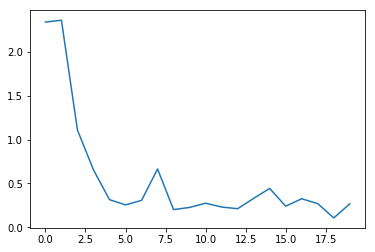

In [75]:
x_axis = np.arange(len(Error))
plt.plot(x_axis, Error)
plt.show()

<br/><br/>

## 5-2. Test
<br/><br/>
이제 `Validation DataSet`을 이용하여 학습한 것이 잘 되었는지 확인해봅시다.

학습이 완료된 가중치들을 이용하여 임의의 `입력`데이터를 넣고, 출력된 값들 중에 제일 높은 값이

원하는 `label value`를 뽑아내는지 확인합니다.


<br/>

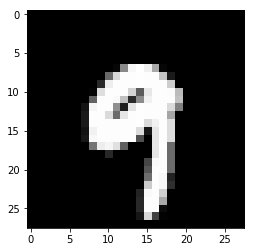

Predict value : 9, label value : 9, OutPut scalar : 

[[ 0.00028982234  0.0049268711  0.00014108744  0.020909734  0.16428822
   0.013100093  0.0031947716  0.0083385911  0.023610255  0.90658879]]


In [76]:
num_of_valid = len(val_img)
arr = np.arange(num_of_valid)
np.random.shuffle(arr)

classes = 10
label = np.array([int(i==int(val_label[arr[0]])) for i in range(classes)]).reshape(classes,1)
Input = val_img[arr[0]]
plt.imshow(Input, cmap='Greys_r')
plt.show()

Input = Input.reshape(784,1)


A1, caches1 = linear_activation_forward(Input, parameters["W1"], parameters["b1"], "sigmoid")
A2, caches2 = linear_activation_forward(A1, parameters["W2"], parameters["b2"], "sigmoid")
A3, caches3 = linear_activation_forward(A2, parameters["W3"], parameters["b3"], "sigmoid")

val = np.argmax(A3)
print("Predict value : {}, label value : {}, OutPut scalar : \n\n{}".format(val, val_label[arr[0]],A3.reshape(1,10)))

<br/><br/>

## 6. Neural Network Tutorial with MNIST for Tensorflow
<br/><br/>
이제 `Tensorflow`를 이용하여 위의 코드를 그대로 구현해보도록 하겠습니다..

`Tensorflow`도 위 코드와 같은 과정을 거치지만, 조금 더 편리하고 간편하게 사용할 수 있습니다.


<br/>

In [77]:
import tensorflow as tf

# 미니배치 사이즈
batch_size = 100
# 학습률
learning_rate = 1
# 훈련 스텝
step_num = 2000

'''
네트워크 옵션
'''
image_size = 28
class_num = 10


# 입력 레이어
x = tf.placeholder(tf.float32, [None, image_size, image_size])
# 3-D shape (batch_size,  width, height)을 2-D (batch_size, num_channel*width*height)로 변환
x_reshape = tf.reshape(x, [-1, image_size*image_size])
# 히든 레이어
W1 = tf.Variable(tf.truncated_normal([image_size*image_size, 1000], stddev=1.0 / math.sqrt(float(image_size*image_size))))
b1 = tf.Variable(tf.zeros([1000]))
h1 = tf.nn.sigmoid(tf.matmul(x_reshape, W1) + b1)
# 히든 레이어
W2 = tf.Variable(tf.truncated_normal([1000, 100], stddev=1.0 / math.sqrt(float(1000))))
b2 = tf.Variable(tf.zeros([100]))
h2 = tf.nn.sigmoid(tf.matmul(h1, W2) + b2)
# 출력 레이어
W3 = tf.Variable(tf.truncated_normal([100, class_num], stddev=1.0 / math.sqrt(float(100))))
b3 = tf.Variable(tf.zeros([class_num]))
model = tf.matmul(h2, W3) + b3

# 목표 출력
y_ = tf.placeholder(tf.int64, [None])
y_ = tf.to_int64(y_)

Error = []
'''
훈련하기
'''
# 손실 함수 정의
cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_, logits=model)
loss = tf.reduce_mean(cross_entropy)

# 옵티마이저 초기화 (SGD)
optimizer = tf.train.GradientDescentOptimizer(learning_rate)
global_step = tf.Variable(0, name='global_step', trainable=False)
train_op = optimizer.minimize(loss, global_step=global_step)

# 세션 생성
sess = tf.Session()

# 글로벌 파라미터 초기화
init = tf.initialize_all_variables()
sess.run(init)

# 학습하기
batch_num = 0
shuffle_index = [i for i in range(train_img.shape[0])]
for step in range(step_num):
    if (batch_num+1) * batch_size <= train_img.shape[0]:
        batch_xs = train_img[shuffle_index[batch_num*batch_size:(batch_num+1)*batch_size]]
        batch_ys = train_label[shuffle_index[batch_num*batch_size:(batch_num+1)*batch_size]]
        _, loss_value = sess.run([train_op, loss], feed_dict={x: batch_xs, y_: batch_ys})

    if (step % 1000) and (step > 0) is 0:
        learning_rate /= 10
        
    if (step % 100) == 0:
        print('Step %d: loss = %.5f' % (step, loss_value))
        Error.append(loss_value)
        batch_num += 1
    else:
        batch_num = 0
        shuffle(shuffle_index)


'''
평가하기
'''
correct_prediction = tf.equal(tf.argmax(model, 1), y_)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

eval_accuracy = 0.0
batch_num = 0
while (batch_num+1) * batch_size <= val_img.shape[0]:
    batch_xs = val_img[batch_num * batch_size:(batch_num + 1) * batch_size]
    batch_ys = val_label[batch_num * batch_size:(batch_num + 1) * batch_size]
    step_eval_accuracy = sess.run(accuracy, feed_dict={x: batch_xs, y_: batch_ys})
    eval_accuracy = eval_accuracy + step_eval_accuracy
    batch_num += 1


print('Validation accuracy: %f%%' % (eval_accuracy / batch_num * 100,))

Step 0: loss = 2.42371
Step 100: loss = 3.00368
Step 200: loss = 0.61670
Step 300: loss = 0.53432
Step 400: loss = 0.38100
Step 500: loss = 0.31806
Step 600: loss = 0.40912
Step 700: loss = 0.47439
Step 800: loss = 0.38173
Step 900: loss = 0.25130
Step 1000: loss = 0.34045
Step 1100: loss = 0.29659
Step 1200: loss = 0.28129
Step 1300: loss = 0.28989
Step 1400: loss = 0.32507
Step 1500: loss = 0.32758
Step 1600: loss = 0.24086
Step 1700: loss = 0.14279
Step 1800: loss = 0.15889
Step 1900: loss = 0.11391
Validation accuracy: 94.330000%


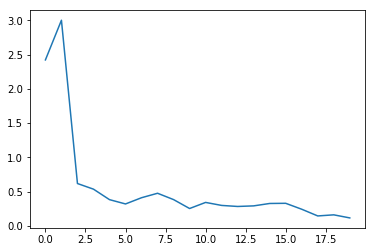

In [78]:
x_axis = np.arange(len(Error))
plt.plot(x_axis, Error)
plt.show()

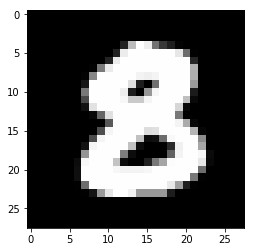

Predict value : 8, label value : 8, OutPut scalar : 

[[ 0.54205638 -2.71806812  1.45435071  2.28268123 -4.00557804 -0.20151377
  -2.92725039 -3.06012225  7.19456005 -0.30789354]]


In [81]:
num_of_valid = len(val_img)
arr = np.arange(num_of_valid)
np.random.shuffle(arr)

Input = val_img[arr[0]]
label = val_label[arr[0]]
plt.imshow(Input, cmap='Greys_r')
plt.show()

X = Input.reshape(1,28,28)
result = sess.run(model, feed_dict={x: X})

val = np.argmax(result)
print("Predict value : {}, label value : {}, OutPut scalar : \n\n{}".format(val, label,result))